# Gnosis Safe

In [21]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from shroomdk import ShroomDK
from sklearn.pipeline import make_pipeline
from sklearn.compose import ColumnTransformer
from sklearn.cluster import KMeans
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler 
from scipy.stats import zscore
from scipy.spatial.distance import cdist
from sklearn.preprocessing import PowerTransformer

In [22]:
#Setting up shroomDK powered by Flipside
my_address = '0x06ED7E490144D4b74BD1C9F33F69DA402603540E'
key = '74d495c5-4a92-4d2f-baf4-b0296d042dcb'
sdk = ShroomDK(key)

In [23]:
safe_addresses = pd.read_csv('Safe user allocations - reworked - Sheet1.csv')

def create_sql_list(df,col):
    df_new = ""
    inputs = list(df[col])
    i = 0
    for row in inputs:
        if i < len(inputs) - 1:
            df_new = df_new + "lower('" + row + "'),"
        else:
            df_new = df_new + "lower('" + row + "')"
        i += 1
    df_new = df_new + ""
    return df_new   

In [24]:
def get_contract_info(string):
    sql = f"""
    SELECT
    contract_address ,
    COUNT(tx_hash) as "# of txs",
    CURRENT_DATE - MIN(DATE(block_timestamp)) as "Days since First Created",
    CURRENT_DATE - MAX(DATE(block_timestamp)) as "Days since Last Used",
    MAX(DATE(block_timestamp)) - MIN(DATE(block_timestamp)) as "Activity Span",
    COUNT(DISTINCT(origin_from_address)) as "Unique Addresses From",
    COUNT(DISTINCT(origin_to_address)) as "Unique Addresses To"
    FROM ethereum.core.fact_event_logs
    WHERE contract_address in ({string})
    GROUP BY contract_address
    """
    query_result_set = sdk.query(
    sql)

    contracts = pd.DataFrame(query_result_set.records)
    contracts
    return contracts


In [25]:
max_number =round(len(safe_addresses) / 1000)
i = 0
df = pd.DataFrame()
while i < max_number:
    first= i*1000
    second= 1000 + i*1000
    if first % 10000 == 0:
        print (f"{i / max_number } % Complete")
    string =create_sql_list(safe_addresses[first:second],'safe_address')
    contracts = get_contract_info(string)
    df = pd.concat([df, contracts])
    i += 1
    

0.0 % Complete
0.17857142857142858 % Complete
0.35714285714285715 % Complete
0.5357142857142857 % Complete
0.7142857142857143 % Complete
0.8928571428571429 % Complete


In [26]:
df.columns

Index(['contract_address', '# of txs', 'days since first created',
       'days since last used', 'activity span', 'unique addresses from',
       'unique addresses to'],
      dtype='object')

In [27]:
df['Low txs'] = df["# of txs"].apply(lambda x: 1 if x < 5 else 0)
df['Short Activity'] = df["activity span"].apply(lambda x: 1 if x < 3 else 0)
df["Low From"] = df["unique addresses from"].apply(lambda x: 1 if x < 2 else 0)
df["Low To"] = df["unique addresses to"].apply(lambda x: 1 if x < 2 else 0)

<AxesSubplot:xlabel='# of txs', ylabel='Count'>

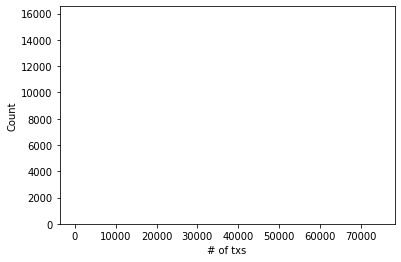

In [28]:
sns.histplot(x='# of txs',data = df)

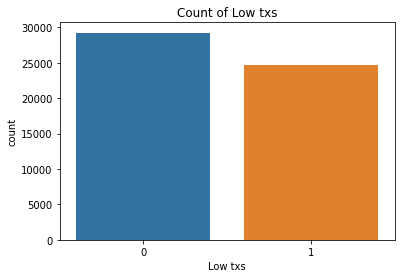

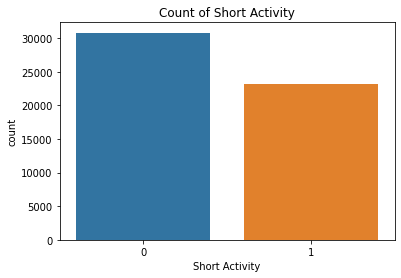

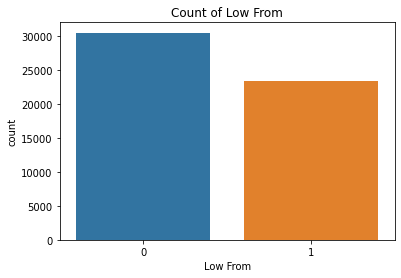

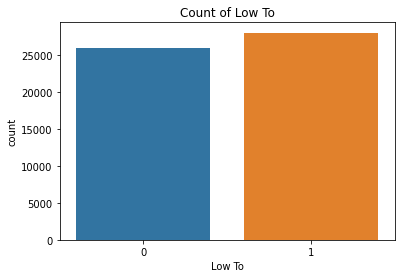

In [29]:
for col in ['Low txs','Short Activity','Low From','Low To'] :
    plt.figure()
    plt.title(f'Count of {col}')
    sns.countplot(x=col,data = df)

In [30]:
a = "('0x0000000b71f2d236c38ae51952c46f03b89d0777','0x00004ee398ca93038d193dd34e89db467a298536','0x00008ca94c831a8d89eb701be216ea2f8c260004')"
# sql = f"""
# SELECT * 
# FROM ethereum.core.fact_event_logs
# WHERE EVENT_NAME = 'ExecutionSuccess'
# and contract_address IN {safe}
# LIMIT 20
# """
sql = f"""
--origin_from who created  it
--contract - safe address
WITH proxy_owners as (SELECT
block_timestamp,
tx_hash,
origin_from_address,
contract_address,
CONCAT('0x',substr(data,347,40)) AS Address1,
CONCAT('0x',substr(data,347+64,40)) AS Address2,
CONCAT('0x',substr(data,347+(64*2),40)) AS Address3,
CONCAT('0x',substr(data,347+(64*3),40)) AS Address4,
CONCAT('0x',substr(data,347+(64*4),40)) AS Address5,
CONCAT('0x',substr(data,347+(64*5),40)) AS Address6,
CONCAT('0x',substr(data,347+(64*6),40)) AS Address7,
CONCAT('0x',substr(data,347+(64*7),40)) AS Address8
FROM ethereum.core.fact_event_logs
LEFT JOIN (SELECT tx_hash as tx
FROM ethereum.core.fact_event_logs
WHERE EVENT_NAME = 'ProxyCreation' and CONTRACT_NAME = 'GnosisSafeProxyFactory'
) n ON tx = tx_hash
WHERE tx is NOT NULL
and  CONTRACT_NAME IS NULL
and origin_from_address = CONCAT('0x',substr(data,347,40))
and DATE(block_timestamp) < '2022-08-18'
)
  
SELECT
block_timestamp,
tx_hash,
contract_address as safe_address,
Address1 as owner
FROM proxy_owners
WHERE Address1 != '0x'

UNION ALL

SELECT
block_timestamp,
tx_hash,
contract_address as safe_address,
Address2 as owner
FROM proxy_owners
WHERE Address2 != '0x'

UNION ALL
  
SELECT
block_timestamp,
tx_hash,
contract_address as safe_address,
Address3 as owner
FROM proxy_owners
WHERE Address3 != '0x'

UNION ALL

SELECT
block_timestamp,
tx_hash,
contract_address as safe_address,
Address4 as owner
FROM proxy_owners
WHERE Address4 != '0x'

UNION ALL
  
SELECT
block_timestamp,
tx_hash,
contract_address as safe_address,
Address5 as owner
FROM proxy_owners
WHERE Address5 != '0x'

UNION ALL
  
SELECT
block_timestamp,
tx_hash,
contract_address as safe_address,
Address6 as owner
FROM proxy_owners
WHERE Address6 != '0x'

UNION ALL
  
SELECT
block_timestamp,
tx_hash,
contract_address as safe_address,
Address7 as owner
FROM proxy_owners
WHERE Address7 != '0x'

UNION ALL
  
SELECT
block_timestamp,
tx_hash,
contract_address as safe_address,
Address8 as owner
FROM proxy_owners
WHERE Address8 != '0x'


"""

# Run the query against Flipside's query engine 
# and await the results
query_result_set = sdk.query(
sql)

owners_safe = pd.DataFrame(query_result_set.records)
owners_safe = owners_safe.drop_duplicates()

In [31]:
owners_safe = pd.merge(owners_safe,safe_addresses,left_on = 'safe_address', right_on = 'safe_address', how = 'left')
owners_safe = owners_safe[~owners_safe['tokens'].isna()]
owners_safe = pd.merge(owners_safe,df,left_on='safe_address', right_on='contract_address',how = 'left')


In [32]:
owners_safe[~owners_safe["# of txs"].isna()]

,block_timestamp,tx_hash,safe_address,owner,tokens,contract_address,# of txs,days since first created,days since last used,activity span,unique addresses from,unique addresses to,Low txs,Short Activity,Low From,Low To
0,2022-07-05 20:05:02.000,0x13974151e8eef81862cc0d3eae3420bc82bae6570a8e...,0xadc8828495db4ae6a29402792c80fc509539c679,0x80f718f8e3da7efb5a87fbfa67d2f5aa7bd1f0ce,549.112954,0xadc8828495db4ae6a29402792c80fc509539c679,5,71,71,0,1,2,0,1,1,0
1,2022-07-12 23:08:42.000,0x9c613cb88192d3d360fd3317b23ebc4a075736b8abbb...,0xd1e70efc9415b147ee96daf134d8673db9b98bc0,0x7b888aa60ac4c88ebd382cb229f9f543ca6dcc8c,903.093009,0xd1e70efc9415b147ee96daf134d8673db9b98bc0,1,64,64,0,1,1,1,1,1,1
2,2022-07-12 18:24:39.000,0xf5723bd5c3542a01abc7dd39a4e39830fffbbe1bf802...,0xdd8784bea9cab617368008ba54665c7e311aa539,0x8170f9304373dc5eb1cb91cd1edf878769c69b3c,268.801162,0xdd8784bea9cab617368008ba54665c7e311aa539,7,64,58,6,2,2,0,0,0,0
3,2022-07-11 05:20:55.000,0xcd1f9dd54a24c88a889c2fb4f64758171da4f53470ee...,0x8a44900091cb7ad061b53dfe3f63a3e52e96b90e,0x5d32e91be8ef9fdf1ce926f63db341418093851e,483.662711,0x8a44900091cb7ad061b53dfe3f63a3e52e96b90e,67,65,48,17,3,2,0,0,0,0
4,2022-07-11 05:08:54.000,0x7dffee428b57d2790344adc3d4256fdab060a27f4940...,0xe47f75dd5db061ac1629219f34611ab61f9f2acf,0x81dd5ce183a972cb1ea605b7d806ea425612d1b6,143.517539,0xe47f75dd5db061ac1629219f34611ab61f9f2acf,3,65,65,0,1,2,1,1,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
51279,2022-04-27 00:23:44.000,0xffbc33e32367fc092652653898f2aef1ed501f229813...,0x6bec895a4270b3cf232a9eef832919472cbea4c2,0xc890b59643f9dca83bd1aac031061a9486e49e99,346.557485,0x6bec895a4270b3cf232a9eef832919472cbea4c2,2,140,140,0,2,2,1,1,0,0
51280,2022-04-23 07:34:07.000,0x5ec3ffbabebc7953171d1e0eeca62ca7a59503230ecb...,0x06b148cf747143e43139c184c3e358cf6331c218,0xaeaf8371bf9df3edb08bdd7d05099d49965fdf59,132.672731,0x06b148cf747143e43139c184c3e358cf6331c218,2,144,138,6,2,2,1,0,0,0
51281,2022-05-06 23:13:37.000,0x52770ef581be0ffbeedc9f1f921f8ddfac423a9ce423...,0x78ef4d4b3f0e8df5bf543d5d8a5d3f8c26c59adc,0x1220e2393fee925fa532ec44ec39d0321c7bff3b,214.660998,0x78ef4d4b3f0e8df5bf543d5d8a5d3f8c26c59adc,2,131,58,73,1,2,1,0,1,0
51282,2022-05-06 20:37:13.000,0x62a91dad805e66ee79a0170c1602722eb84c260d2a42...,0xb0073a64d1424ff800262814fd65e29aecef5a46,0x5d10b1cf6b9fdb2bd090601f2e7de610576e3976,494.779858,0xb0073a64d1424ff800262814fd65e29aecef5a46,12,131,41,90,6,2,0,0,0,0


In [33]:
safe_address_agg = pd.DataFrame(owners_safe.groupby('safe_address')['owner'].nunique()).rename(columns={'owner': '# of Owners for Safe Address'})
wallet_agg = pd.DataFrame(owners_safe.groupby('owner')['safe_address'].nunique()).rename(columns={'safe_address':'# of Wallets Owner Has'})
owners_safe = pd.merge(owners_safe,wallet_agg, on = 'owner',how = 'left')
owners_safe = pd.merge(owners_safe,safe_address_agg, on = 'safe_address', how = 'left')
#owners_safe.groupby(['owner'])['tokens'].transform(lambda x : zscore(x,ddof=1)).rename(columns={'safe_address':'# of Wallets Owner Has'})

owners_safe['Owns More Than 4 Safes']  = owners_safe['# of Wallets Owner Has'].apply(lambda x: 1 if  x > 4 else 0 )

In [34]:
owners_safe

,block_timestamp,tx_hash,safe_address,owner,tokens,contract_address,# of txs,days since first created,days since last used,activity span,unique addresses from,unique addresses to,Low txs,Short Activity,Low From,Low To,# of Wallets Owner Has,# of Owners for Safe Address,Owns More Than 4 Safes
0,2022-07-05 20:05:02.000,0x13974151e8eef81862cc0d3eae3420bc82bae6570a8e...,0xadc8828495db4ae6a29402792c80fc509539c679,0x80f718f8e3da7efb5a87fbfa67d2f5aa7bd1f0ce,549.112954,0xadc8828495db4ae6a29402792c80fc509539c679,5,71,71,0,1,2,0,1,1,0,1,2,0
1,2022-07-12 23:08:42.000,0x9c613cb88192d3d360fd3317b23ebc4a075736b8abbb...,0xd1e70efc9415b147ee96daf134d8673db9b98bc0,0x7b888aa60ac4c88ebd382cb229f9f543ca6dcc8c,903.093009,0xd1e70efc9415b147ee96daf134d8673db9b98bc0,1,64,64,0,1,1,1,1,1,1,1,1,0
2,2022-07-12 18:24:39.000,0xf5723bd5c3542a01abc7dd39a4e39830fffbbe1bf802...,0xdd8784bea9cab617368008ba54665c7e311aa539,0x8170f9304373dc5eb1cb91cd1edf878769c69b3c,268.801162,0xdd8784bea9cab617368008ba54665c7e311aa539,7,64,58,6,2,2,0,0,0,0,1,3,0
3,2022-07-11 05:20:55.000,0xcd1f9dd54a24c88a889c2fb4f64758171da4f53470ee...,0x8a44900091cb7ad061b53dfe3f63a3e52e96b90e,0x5d32e91be8ef9fdf1ce926f63db341418093851e,483.662711,0x8a44900091cb7ad061b53dfe3f63a3e52e96b90e,67,65,48,17,3,2,0,0,0,0,1,2,0
4,2022-07-11 05:08:54.000,0x7dffee428b57d2790344adc3d4256fdab060a27f4940...,0xe47f75dd5db061ac1629219f34611ab61f9f2acf,0x81dd5ce183a972cb1ea605b7d806ea425612d1b6,143.517539,0xe47f75dd5db061ac1629219f34611ab61f9f2acf,3,65,65,0,1,2,1,1,1,0,1,2,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
51279,2022-04-27 00:23:44.000,0xffbc33e32367fc092652653898f2aef1ed501f229813...,0x6bec895a4270b3cf232a9eef832919472cbea4c2,0xc890b59643f9dca83bd1aac031061a9486e49e99,346.557485,0x6bec895a4270b3cf232a9eef832919472cbea4c2,2,140,140,0,2,2,1,1,0,0,1,4,0
51280,2022-04-23 07:34:07.000,0x5ec3ffbabebc7953171d1e0eeca62ca7a59503230ecb...,0x06b148cf747143e43139c184c3e358cf6331c218,0xaeaf8371bf9df3edb08bdd7d05099d49965fdf59,132.672731,0x06b148cf747143e43139c184c3e358cf6331c218,2,144,138,6,2,2,1,0,0,0,1,4,0
51281,2022-05-06 23:13:37.000,0x52770ef581be0ffbeedc9f1f921f8ddfac423a9ce423...,0x78ef4d4b3f0e8df5bf543d5d8a5d3f8c26c59adc,0x1220e2393fee925fa532ec44ec39d0321c7bff3b,214.660998,0x78ef4d4b3f0e8df5bf543d5d8a5d3f8c26c59adc,2,131,58,73,1,2,1,0,1,0,1,4,0
51282,2022-05-06 20:37:13.000,0x62a91dad805e66ee79a0170c1602722eb84c260d2a42...,0xb0073a64d1424ff800262814fd65e29aecef5a46,0x5d10b1cf6b9fdb2bd090601f2e7de610576e3976,494.779858,0xb0073a64d1424ff800262814fd65e29aecef5a46,12,131,41,90,6,2,0,0,0,0,1,4,0


<AxesSubplot:title={'center':'Owns More Than 4 Safes'}, xlabel='Owns More Than 4 Safes', ylabel='count'>

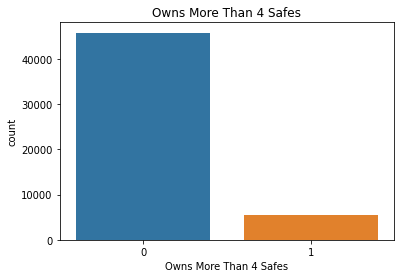

In [35]:
plt.figure()
plt.title(f'Owns More Than 4 Safes')
sns.countplot(x='Owns More Than 4 Safes',data = owners_safe)

<AxesSubplot:title={'center':'Distribution of Number of Safes Owner Has'}, xlabel='# of Wallets Owner Has', ylabel='Count'>

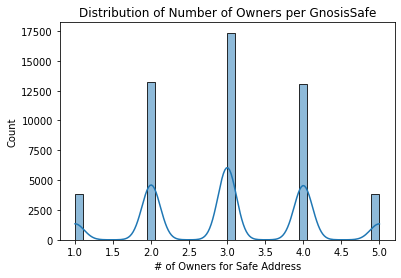

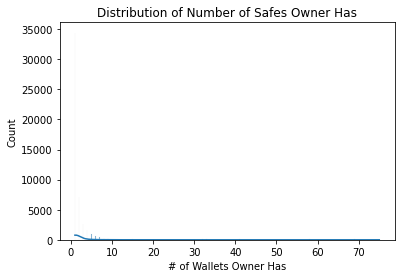

In [36]:
plt.figure()
plt.title('Distribution of Number of Owners per GnosisSafe')
sns.histplot(x='# of Owners for Safe Address',data=owners_safe, kde = True)

plt.figure()
plt.title('Distribution of Number of Safes Owner Has')
sns.histplot(x='# of Wallets Owner Has', data=owners_safe, kde = True)


In [37]:
def get_owner_info(string):
    sql = f"""
    WITH addy as (SELECT
    tx_hash,
    EVENT_NAME,
    origin_from_address as address,
    block_timestamp,
    origin_to_address as interact,
    contract_address
    FROM ethereum.core.fact_event_logs
    WHERE origin_from_address in ({string})

    UNION ALL

    SELECT 
    tx_hash,
    EVENT_NAME,
    origin_from_address as address,
    block_timestamp,
    origin_to_address as interact,
    contract_address
    FROM ethereum.core.fact_event_logs
    WHERE origin_from_address in ({string})
    )

    SELECT 
      address,
      CURRENT_DATE -  MIN(DATE(block_timestamp)) as days_since_first_tx,
      CURRENT_DATE -  MAX(DATE(block_timestamp)) as days_since_last_tx,
       MAX(DATE(block_timestamp)) - MIN(DATE(block_timestamp)) as activity_span,
      COUNT(DISTINCT(tx_hash)) as no_owner_tx,
      COUNT(DISTINCT(contract_address)) as no_contracts,
      COUNT(DISTINCT(EVENT_NAME)) as no_events,
      COUNT(DISTINCT(interact)) as unique_addresses_interact
    FROM addy 
    GROUP BY address 
    """
    query_result_set = sdk.query(
        sql)

    owner = pd.DataFrame(query_result_set.records)
    return owner


In [38]:
un = pd.DataFrame(owners_safe['owner'].drop_duplicates())

max_number =round(len(un) / 1000)
i = 0
own = pd.DataFrame()
while i < max_number:
    first= i*1000
    second= 1000 + i*1000
    if first % 10000 == 0:
        print (f"{i / max_number } % Complete")
    string =create_sql_list(un[first:second],'owner')
    contracts = get_owner_info(string)
    own = pd.concat([own, contracts])
    print(i)
    i += 1
    

0.0 % Complete
0
1
2
3
4
5
6
7
8
9
0.25 % Complete
10
11
12
13
14
15
16
17
18
19
0.5 % Complete
20
21
22
23
24
25
26
27
28
29
0.75 % Complete
30
31
32
33
34
35
36
37
38
39


In [39]:
own['Short Activity Own'] = own['activity_span'].apply(lambda x: 1 if x < 7 else 0)
own['Low Tx Own'] = own['no_owner_tx'].apply(lambda x: 1 if x < 10 else 0 )
own['Low Events'] = own['no_events'].apply(lambda x: 1 if x < 5 else 0)
own['Low Contract'] = own['no_contracts'].apply(lambda x: 1 if x < 5 else 0)
own['Low Addresses'] = own['unique_addresses_interact'].apply(lambda x: 1 if x < 5 else 0)

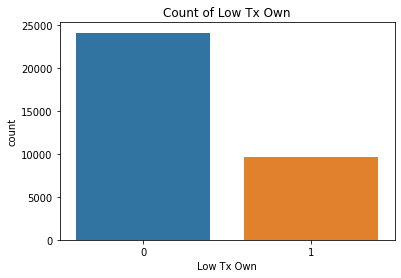

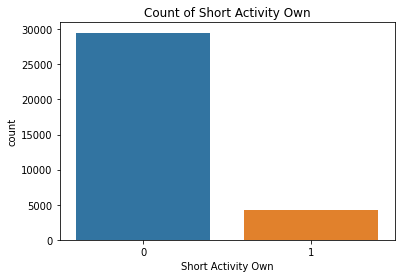

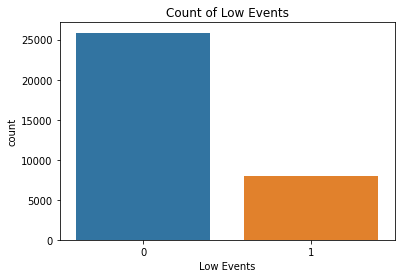

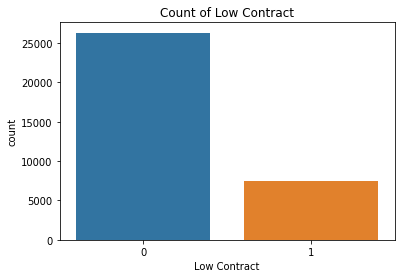

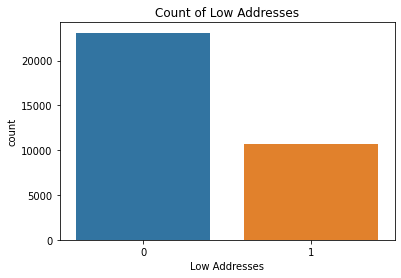

In [40]:
for col in ['Low Tx Own','Short Activity Own','Low Events','Low Contract', 'Low Addresses']:
    plt.figure()
    plt.title(f'Count of {col}')
    sns.countplot(x=col,data = own)

In [41]:
owners_safe = pd.merge(owners_safe,own,left_on = 'owner', right_on = 'address',how = 'left')

In [42]:
owners_safe

,block_timestamp,tx_hash,safe_address,owner,tokens,contract_address,# of txs,days since first created,days since last used,activity span,...,activity_span,no_owner_tx,no_contracts,no_events,unique_addresses_interact,Short Activity Own,Low Tx Own,Low Events,Low Contract,Low Addresses
0,2022-07-05 20:05:02.000,0x13974151e8eef81862cc0d3eae3420bc82bae6570a8e...,0xadc8828495db4ae6a29402792c80fc509539c679,0x80f718f8e3da7efb5a87fbfa67d2f5aa7bd1f0ce,549.112954,0xadc8828495db4ae6a29402792c80fc509539c679,5,71,71,0,...,0.0,5.0,3.0,4.0,2.0,1.0,1.0,1.0,1.0,1.0
1,2022-07-12 23:08:42.000,0x9c613cb88192d3d360fd3317b23ebc4a075736b8abbb...,0xd1e70efc9415b147ee96daf134d8673db9b98bc0,0x7b888aa60ac4c88ebd382cb229f9f543ca6dcc8c,903.093009,0xd1e70efc9415b147ee96daf134d8673db9b98bc0,1,64,64,0,...,0.0,2.0,3.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
2,2022-07-12 18:24:39.000,0xf5723bd5c3542a01abc7dd39a4e39830fffbbe1bf802...,0xdd8784bea9cab617368008ba54665c7e311aa539,0x8170f9304373dc5eb1cb91cd1edf878769c69b3c,268.801162,0xdd8784bea9cab617368008ba54665c7e311aa539,7,64,58,6,...,566.0,1094.0,516.0,118.0,329.0,0.0,0.0,0.0,0.0,0.0
3,2022-07-11 05:20:55.000,0xcd1f9dd54a24c88a889c2fb4f64758171da4f53470ee...,0x8a44900091cb7ad061b53dfe3f63a3e52e96b90e,0x5d32e91be8ef9fdf1ce926f63db341418093851e,483.662711,0x8a44900091cb7ad061b53dfe3f63a3e52e96b90e,67,65,48,17,...,945.0,109.0,73.0,57.0,48.0,0.0,0.0,0.0,0.0,0.0
4,2022-07-11 05:08:54.000,0x7dffee428b57d2790344adc3d4256fdab060a27f4940...,0xe47f75dd5db061ac1629219f34611ab61f9f2acf,0x81dd5ce183a972cb1ea605b7d806ea425612d1b6,143.517539,0xe47f75dd5db061ac1629219f34611ab61f9f2acf,3,65,65,0,...,59.0,20.0,15.0,11.0,12.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
51279,2022-04-27 00:23:44.000,0xffbc33e32367fc092652653898f2aef1ed501f229813...,0x6bec895a4270b3cf232a9eef832919472cbea4c2,0xc890b59643f9dca83bd1aac031061a9486e49e99,346.557485,0x6bec895a4270b3cf232a9eef832919472cbea4c2,2,140,140,0,...,42.0,3.0,4.0,4.0,1.0,0.0,1.0,1.0,1.0,1.0
51280,2022-04-23 07:34:07.000,0x5ec3ffbabebc7953171d1e0eeca62ca7a59503230ecb...,0x06b148cf747143e43139c184c3e358cf6331c218,0xaeaf8371bf9df3edb08bdd7d05099d49965fdf59,132.672731,0x06b148cf747143e43139c184c3e358cf6331c218,2,144,138,6,...,296.0,34.0,31.0,25.0,23.0,0.0,0.0,0.0,0.0,0.0
51281,2022-05-06 23:13:37.000,0x52770ef581be0ffbeedc9f1f921f8ddfac423a9ce423...,0x78ef4d4b3f0e8df5bf543d5d8a5d3f8c26c59adc,0x1220e2393fee925fa532ec44ec39d0321c7bff3b,214.660998,0x78ef4d4b3f0e8df5bf543d5d8a5d3f8c26c59adc,2,131,58,73,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
51282,2022-05-06 20:37:13.000,0x62a91dad805e66ee79a0170c1602722eb84c260d2a42...,0xb0073a64d1424ff800262814fd65e29aecef5a46,0x5d10b1cf6b9fdb2bd090601f2e7de610576e3976,494.779858,0xb0073a64d1424ff800262814fd65e29aecef5a46,12,131,41,90,...,216.0,26.0,15.0,14.0,9.0,0.0,0.0,0.0,0.0,0.0


In [43]:
#Airdrop Info

token = ['LOOKs','HOP','ENS','SOS','1INCH','Ribbon',
         'AMP','X2Y2',
         #'PSP',
         'EULER','BEND','UNI','DYDX']

from_address = ['0xA35dce3e0E6ceb67a30b8D7f4aEe721C949B5970',
                '0xc5102fE9359FD9a28f877a67E36B0F050d81a3CC',
                '0xc18360217d8f7ab5e7c516566761ea12ce7f9d72',
                #'0x5a5ecd062083733c9aa27cb4c5f113c42f730261',
                '0x0000000000000000000000000000000000000000',
                '0xe295ad71242373c37c5fda7b57f26f9ea1088afe',
                '0x7902e4bfb1eb9F4559d55417Aee1Dc6E4b8cC1Bf',
                '0xF497b83CfBd31E7Ba1Ab646F3B50aE0aF52d03A1',
                '0xe6949137b24ad50cce2cf6b124b3b874449a41fa',
                #'0xcAfE001067cDEF266AfB7Eb5A286dCFD277f3dE5',
                '0xd524e29e3baf5bb085403ca5665301e94387a7e2',
                '0x1b5d2904be3e4711a848be09b17dee89e6a5bc27',
                '0x090d4613473dee047c3f2706764f49e0821d256e',
                '0x639192d54431f8c816368d3fb4107bc168d0e871'
                
                
                ]
contract_address = ['0xf4d2888d29d722226fafa5d9b24f9164c092421e',
                   '0xc5102fE9359FD9a28f877a67E36B0F050d81a3CC',
                   '0xc18360217d8f7ab5e7c516566761ea12ce7f9d72',
                   '0x3b484b82567a09e2588a13d54d032153f0c0aee0',
                   '0x111111111117dc0aa78b770fa6a738034120c302',
                   '0x6123b0049f904d730db3c36a31167d9d4121fa6b',
                    '0x77fba179c79de5b7653f68b5039af940ada60ce0',
                    '0x1e4ede388cbc9f4b5c79681b7f94d36a11abebc9',
                    #'0x090E53c44E8a9b6B1bcA800e881455b921AEC420',
                    '0xd9Fcd98c322942075A5C3860693e9f4f03AAE07b',
                    '0x0d02755a5700414b26ff040e1de35d337df56218',
                    '0x1f9840a85d5aF5bf1D1762F925BDADdC4201F984',
                    '0x92D6C1e31e14520e676a687F0a93788B716BEff5'
                   ]
print(len(contract_address))
print(len(from_address))

df_airdrops = pd.DataFrame({
    'Token':token,
    'From Address':from_address,
    'Contract Address': contract_address
})

12
12


In [44]:
#functions query airdropers that have dumped a particular token in less than a week of a holding (wallet balence = 0)
def find_airdroppers(token,address,contract,owners_safe):
    sql = f"""
    with airdrop_recipients as (SELECT --DISTINCT(origin_to_address) AS hop_address
    block_timestamp as bt,
    to_address as airdrop_recipient,
    contract_address as token
    FROM ethereum.core.fact_token_transfers
    WHERE contract_address = lower('{contract}')
    and from_address = lower('{address}')
    )

    SELECT --distinct(user_address)
    DATEDIFF(day, bt, block_timestamp) as "Time to Drop",
    user_address,
    prev_bal as amount_dumped
    FROM ethereum.core.ez_balance_deltas
    INNER JOIN airdrop_recipients ON airdrop_recipient = user_address and token = contract_address
    WHERE current_bal = 0
    and DATEDIFF(day, bt, block_timestamp) < 14
    """

    query_result_set = sdk.query(
    sql)
    dumpers = pd.DataFrame(query_result_set.records)
    dumpers.columns = [str(col) + '_' + token if col != 'user_address' else col for col in dumpers.columns]
    no_dumpers = len(dumpers)
    print(f'Identifed {no_dumpers} that dumped {token} within a week')
    col_name = 'Dumped ' + token
    dumpers[col_name] = 1
    owners_safe = pd.merge(owners_safe,dumpers,left_on='owner',right_on='user_address',how='left')
    owners_safe = owners_safe.drop(columns=['user_address'])
    no_safes = owners_safe.loc[owners_safe[col_name] == 1,'safe_address'].unique()
    no_addresses = owners_safe.loc[owners_safe[col_name] == 1,'owner'].unique()
    owners_safe = owners_safe.fillna(0)
    owners_safe['Number of Airdrops Dumped'] = owners_safe['Number of Airdrops Dumped'] + owners_safe[col_name]
    #owners_safe['Tokens Dumped'] = owners_safe.apply(lambda x: x['Tokens Dumped'] +", "+ col_name if owners_safe[col_name] == 1 else x['Tokens Dumped'], axis = 1)
    owners_safe['Tokens Dumped'] = np.where(owners_safe[col_name] == 1, owners_safe['Tokens Dumped'] +", "+ col_name, owners_safe['Tokens Dumped'])
    print(f'Identifed {len(no_safes)} safes that had an owner dump {token}')
    print(f'Identifed {len(no_addresses)} owner addresses that dumped {token}')
    return owners_safe, no_dumpers, len(no_safes), len(no_addresses)
    

In [45]:
i = 0
dumped = []
safes = []
addresses = []
dumped_owners_safe = owners_safe[['owner','safe_address']].copy()
dumped_owners_safe['Number of Airdrops Dumped'] = 0
dumped_owners_safe['Tokens Dumped'] = ''
while i < len(df_airdrops):
    token = df_airdrops.loc[i,'Token']
    address = df_airdrops.loc[i,'From Address']
    contract = df_airdrops.loc[i,'Contract Address']
    dumped_owners_safe, no_dumpers, no_safes, no_addresses = find_airdroppers(token,address,contract,dumped_owners_safe)
    dumped.append(no_dumpers)
    safes.append(no_safes)
    addresses.append(no_addresses)
    i += 1
    


Identifed 34047 that dumped LOOKs within a week
Identifed 1048 safes that had an owner dump LOOKs
Identifed 838 owner addresses that dumped LOOKs
Identifed 2448 that dumped HOP within a week
Identifed 197 safes that had an owner dump HOP
Identifed 164 owner addresses that dumped HOP
Identifed 16777 that dumped ENS within a week
Identifed 857 safes that had an owner dump ENS
Identifed 696 owner addresses that dumped ENS
Identifed 50593 that dumped SOS within a week
Identifed 1367 safes that had an owner dump SOS
Identifed 1225 owner addresses that dumped SOS
Identifed 7888 that dumped 1INCH within a week
Identifed 132 safes that had an owner dump 1INCH
Identifed 102 owner addresses that dumped 1INCH
Identifed 26 that dumped Ribbon within a week
Identifed 0 safes that had an owner dump Ribbon
Identifed 0 owner addresses that dumped Ribbon
Identifed 7089 that dumped AMP within a week
Identifed 55 safes that had an owner dump AMP
Identifed 41 owner addresses that dumped AMP
Identifed 4905 

In [46]:
df_airdrops['# of Dumpers'] = dumped
df_airdrops['# of Safes'] = safes
df_airdrops['# of Addresses'] = addresses

<AxesSubplot:title={'center':'# of Gnosis Owners that Dumped by Token'}, xlabel='Token', ylabel='# of Addresses'>

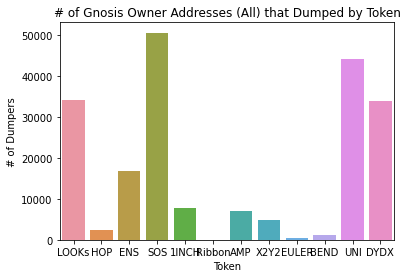

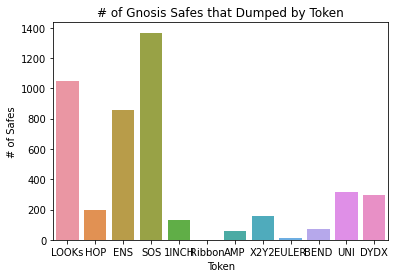

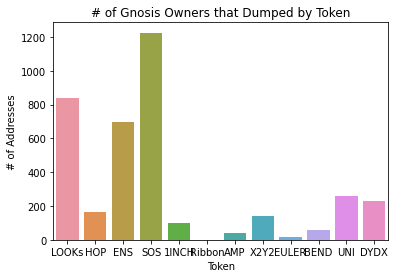

In [47]:
plt.figure()
plt.title('# of Gnosis Owner Addresses (All) that Dumped by Token')
sns.barplot(data=df_airdrops, x="Token", y="# of Dumpers")
plt.figure()
plt.title('# of Gnosis Safes that Dumped by Token')
sns.barplot(data=df_airdrops, x="Token", y="# of Safes")
plt.figure()
plt.title('# of Gnosis Owners that Dumped by Token')
sns.barplot(data=df_airdrops, x="Token", y="# of Addresses")


In [48]:
#dumped_owners_safe[['safe_address','owner','Number of Airdrops Dumped','Tokens Dumped']].sort_values('Number of Airdrops Dumped',ascending = False)
#dumped_owners_safe = dumped_owners_safe.drop(columns = ['dumped_owners_safe','tx_hash'])
owners_safe = pd.merge(owners_safe, dumped_owners_safe,on = ['safe_address','owner'],how = 'left')

In [49]:
owners_safe

,block_timestamp,tx_hash,safe_address,owner,tokens,contract_address,# of txs,days since first created,days since last used,activity span,...,Dumped EULER,time to drop_BEND,amount_dumped_BEND,Dumped BEND,time to drop_UNI,amount_dumped_UNI,Dumped UNI,time to drop_DYDX,amount_dumped_DYDX,Dumped DYDX
0,2022-07-05 20:05:02.000,0x13974151e8eef81862cc0d3eae3420bc82bae6570a8e...,0xadc8828495db4ae6a29402792c80fc509539c679,0x80f718f8e3da7efb5a87fbfa67d2f5aa7bd1f0ce,549.112954,0xadc8828495db4ae6a29402792c80fc509539c679,5,71,71,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2022-07-12 23:08:42.000,0x9c613cb88192d3d360fd3317b23ebc4a075736b8abbb...,0xd1e70efc9415b147ee96daf134d8673db9b98bc0,0x7b888aa60ac4c88ebd382cb229f9f543ca6dcc8c,903.093009,0xd1e70efc9415b147ee96daf134d8673db9b98bc0,1,64,64,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2022-07-12 18:24:39.000,0xf5723bd5c3542a01abc7dd39a4e39830fffbbe1bf802...,0xdd8784bea9cab617368008ba54665c7e311aa539,0x8170f9304373dc5eb1cb91cd1edf878769c69b3c,268.801162,0xdd8784bea9cab617368008ba54665c7e311aa539,7,64,58,6,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,2022-07-11 05:20:55.000,0xcd1f9dd54a24c88a889c2fb4f64758171da4f53470ee...,0x8a44900091cb7ad061b53dfe3f63a3e52e96b90e,0x5d32e91be8ef9fdf1ce926f63db341418093851e,483.662711,0x8a44900091cb7ad061b53dfe3f63a3e52e96b90e,67,65,48,17,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,2022-07-11 05:08:54.000,0x7dffee428b57d2790344adc3d4256fdab060a27f4940...,0xe47f75dd5db061ac1629219f34611ab61f9f2acf,0x81dd5ce183a972cb1ea605b7d806ea425612d1b6,143.517539,0xe47f75dd5db061ac1629219f34611ab61f9f2acf,3,65,65,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
52763,2022-04-27 00:23:44.000,0xffbc33e32367fc092652653898f2aef1ed501f229813...,0x6bec895a4270b3cf232a9eef832919472cbea4c2,0xc890b59643f9dca83bd1aac031061a9486e49e99,346.557485,0x6bec895a4270b3cf232a9eef832919472cbea4c2,2,140,140,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
52764,2022-04-23 07:34:07.000,0x5ec3ffbabebc7953171d1e0eeca62ca7a59503230ecb...,0x06b148cf747143e43139c184c3e358cf6331c218,0xaeaf8371bf9df3edb08bdd7d05099d49965fdf59,132.672731,0x06b148cf747143e43139c184c3e358cf6331c218,2,144,138,6,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
52765,2022-05-06 23:13:37.000,0x52770ef581be0ffbeedc9f1f921f8ddfac423a9ce423...,0x78ef4d4b3f0e8df5bf543d5d8a5d3f8c26c59adc,0x1220e2393fee925fa532ec44ec39d0321c7bff3b,214.660998,0x78ef4d4b3f0e8df5bf543d5d8a5d3f8c26c59adc,2,131,58,73,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
52766,2022-05-06 20:37:13.000,0x62a91dad805e66ee79a0170c1602722eb84c260d2a42...,0xb0073a64d1424ff800262814fd65e29aecef5a46,0x5d10b1cf6b9fdb2bd090601f2e7de610576e3976,494.779858,0xb0073a64d1424ff800262814fd65e29aecef5a46,12,131,41,90,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [50]:
for i in owners_safe.columns:
    print(i)

block_timestamp
tx_hash
safe_address
owner
tokens
contract_address
# of txs
days since first created
days since last used
activity span
unique addresses from
unique addresses to
Low txs
Short Activity
Low From
Low To
# of Wallets Owner Has
# of Owners for Safe Address
Owns More Than 4 Safes
address
days_since_first_tx
days_since_last_tx
activity_span
no_owner_tx
no_contracts
no_events
unique_addresses_interact
Short Activity Own
Low Tx Own
Low Events
Low Contract
Low Addresses
Number of Airdrops Dumped
Tokens Dumped
time to drop_LOOKs
amount_dumped_LOOKs
Dumped LOOKs
time to drop_HOP
amount_dumped_HOP
Dumped HOP
time to drop_ENS
amount_dumped_ENS
Dumped ENS
time to drop_SOS
amount_dumped_SOS
Dumped SOS
time to drop_1INCH
amount_dumped_1INCH
Dumped 1INCH
time to drop_Ribbon
amount_dumped_Ribbon
Dumped Ribbon
time to drop_AMP
amount_dumped_AMP
Dumped AMP
time to drop_X2Y2
amount_dumped_X2Y2
Dumped X2Y2
time to drop_EULER
amount_dumped_EULER
Dumped EULER
time to drop_BEND
amount_dumped_BE

Number of Dumpers 52768
Number of Safe Addresses: 5245


<AxesSubplot:title={'center':'# of Safe Owners who have Dumped a Token'}, xlabel='Number of Airdrops Dumped', ylabel='Count'>

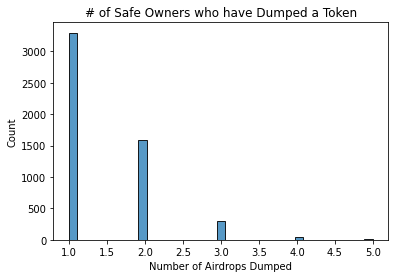

In [77]:
plt.figure("# of Users that Dumped")
plt.title('# of Safe Owners who have Dumped a Token')
print(f"Number of Dumpers {len(dumped_owners_safe)}")
dumpoors = len(dumped_owners_safe.loc[dumped_owners_safe['Number of Airdrops Dumped'] > 0,"safe_address"])
print(f"Number of Safe Addresses: {dumpoors}")
sns.histplot(x = 'Number of Airdrops Dumped',data = dumped_owners_safe[dumped_owners_safe['Number of Airdrops Dumped'] > 0])

In [100]:
owners_safe['Number of Flags'] = owners_safe['Short Activity'] + owners_safe['Low From'] + owners_safe['Low To']
owners_safe['Number of Flags'] = owners_safe['Number of Flags'] + owners_safe['Low Tx Own'] + owners_safe['Short Activity Own'] + owners_safe['Low Events'] + owners_safe['Low Contract'] + owners_safe['Low Addresses']
owners_safe['Number of Flags'] = owners_safe['Number of Airdrops Dumped'] + owners_safe['Owns More Than 4 Safes'] 

#multiple same wallets, low activity
owners_safe['Multiple Wallets, Low Safe Activity'] = owners_safe.apply(lambda x:1 if (x['Owns More Than 4 Safes'] == 1) & (x['Short Activity']  + x['Low txs'] > 1) else 0, axis = 1)

#dumped once and low safe activity
owners_safe['Dumped Previous Airdrop, Low Safe Activity'] = owners_safe.apply(lambda x: 1 if (x['Number of Airdrops Dumped'] >= 1) & (x['Short Activity']  + x['Low txs'] >= 1) else 0, axis = 1)

# #dumped more than two tokens
owners_safe['Dumped Two or More Airdrops'] = owners_safe.apply(lambda x: 1 if x['Number of Airdrops Dumped'] >= 2 else 0,axis = 1)

##safe only used for a day, wallet used for a day
owners_safe['Low Owner Activity, Low Safe Activity'] = owners_safe.apply(lambda x: 1 if (x['Short Activity'] == 1) & ((x['Short Activity Own'] == 1)) else 0, axis = 1)

#safe  has low activity, create wallet on same day as safe
owners_safe['Low Safe Activity, "Created Safe on Same Day'] = owners_safe.apply(lambda x: 1 if (x['days since first created'] == x['days_since_first_tx']) & (x['Short Activity'] == 1) else 0, axis  = 1)

owners_safe['All Flags Description'] = owners_safe['Tokens Dumped']

cols = ['Multiple Wallets, Low Safe Activity','Low Safe Activity, "Created Safe on Same Day','Dumped Two Airdrops','Low Owner Activity, Low Safe Activity','Dumped Previous Airdrop, Low Safe Activity','Short Activity','Low From','Low To','Number of Flags','Low Tx Own','Short Activity Own','Low Events','Low Contract','Low Addresses']

for col_name in cols:
    owners_safe['All Flags Description'] = np.where(owners_safe[col_name] == 1, owners_safe['All Flags Description'] +", "+ col_name, owners_safe['All Flags Description'])
 


In [105]:
owners_safe['Farm'] = owners_safe.apply(lambda x:1 if (x['Low Safe Activity, "Created Safe on Same Day'] + x['Multiple Wallets, Low Safe Activity'] + x['Dumped Previous Airdrop, Low Safe Activity'] + x['Dumped Two Airdrops'] + x['Low Owner Activity, Low Safe Activity'] >= 2) | ( x['Dumped Two Airdrops'] == 1)else 0, axis = 1)
farm = owners_safe[owners_safe['Farm'] == 1]
farm['safe_address'].drop_duplicates().to_csv('Farmed.csv')
farm.to_csv('ALl Farmed.csv')
farm_safe = farm.groupby('safe_address')['Number of Airdrops Dumped','Multiple Wallets, Low Safe Activity','Dumped Two Airdrops','Low Safe Activity, "Created Safe on Same Day','Low Owner Activity, Low Safe Activity','Dumped Previous Airdrop, Low Safe Activity','Short Activity','Low From','Low To','Number of Flags','Low Tx Own','Short Activity Own','Low Events','Low Contract','Low Addresses'].max()
farms_safe = pd.merge(farm_safe,owners_safe[['safe_address','Number of Airdrops Dumped','Tokens Dumped']], on = ['safe_address','Number of Airdrops Dumped'], how = 'left')


farms_safe['All Flags Description'] = farms_safe['Tokens Dumped']

cols = ['Multiple Wallets, Low Safe Activity','Low Safe Activity, "Created Safe on Same Day','Dumped Two Airdrops','Low Owner Activity, Low Safe Activity','Dumped Previous Airdrop, Low Safe Activity','Short Activity','Low From','Low To','Number of Flags','Low Tx Own','Short Activity Own','Low Events','Low Contract','Low Addresses']

for col_name in cols:
    farms_safe['All Flags Description'] = np.where(farms_safe[col_name] == 1, farms_safe['All Flags Description'] +", "+ col_name, farms_safe['All Flags Description'])

print(f"Possible Airdrop Farmers: {len(farms_safe['safe_address'])}")
farms_safe.sort_values('Number of Airdrops Dumped',ascending = False).to_csv('Potiential Airdrop Farmers.csv')
print(farms_safe[['Multiple Wallets, Low Safe Activity','Low Safe Activity, "Created Safe on Same Day','Dumped Two Airdrops','Low Owner Activity, Low Safe Activity','Dumped Previous Airdrop, Low Safe Activity']].sum())
farms_safe.sort_values('Number of Airdrops Dumped',ascending = False).head(100)

C:\Users\jackl\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  """


Possible Airdrop Farmers: 4567
Multiple Wallets, Low Safe Activity              112
Low Safe Activity, "Created Safe on Same Day    2624
Dumped Two Airdrops                             1895
Low Owner Activity, Low Safe Activity           2632
Dumped Previous Airdrop, Low Safe Activity       540
dtype: int64


,safe_address,Number of Airdrops Dumped,"Multiple Wallets, Low Safe Activity",Dumped Two Airdrops,"Low Safe Activity, ""Created Safe on Same Day","Low Owner Activity, Low Safe Activity","Dumped Previous Airdrop, Low Safe Activity",Short Activity,Low From,Low To,Number of Flags,Low Tx Own,Short Activity Own,Low Events,Low Contract,Low Addresses,Tokens Dumped,All Flags Description
2113,0x6d1f9cf37cfb93a2ec0125ba107a251f459cc575,5.0,0,1,0,0,0,0,0,0,5.0,0.0,0.0,0.0,0.0,0.0,", Dumped LOOKs, Dumped HOP, Dumped ENS, Dumped...",", Dumped LOOKs, Dumped HOP, Dumped ENS, Dumped..."
3022,0xa5820c89d6400862424204a7d744dcbf639c19dc,5.0,0,1,0,0,0,0,0,0,5.0,0.0,0.0,0.0,0.0,0.0,", Dumped LOOKs, Dumped 1INCH, Dumped AMP, Dump...",", Dumped LOOKs, Dumped 1INCH, Dumped AMP, Dump..."
2881,0x9d0918a7bcac8e71299a90b3dc17c5a4323d2227,5.0,0,1,0,0,0,0,0,0,5.0,0.0,0.0,0.0,0.0,0.0,", Dumped LOOKs, Dumped ENS, Dumped 1INCH, Dump...",", Dumped LOOKs, Dumped ENS, Dumped 1INCH, Dump..."
2882,0x9d0918a7bcac8e71299a90b3dc17c5a4323d2227,5.0,0,1,0,0,0,0,0,0,5.0,0.0,0.0,0.0,0.0,0.0,", Dumped LOOKs, Dumped ENS, Dumped 1INCH, Dump...",", Dumped LOOKs, Dumped ENS, Dumped 1INCH, Dump..."
2883,0x9d0918a7bcac8e71299a90b3dc17c5a4323d2227,5.0,0,1,0,0,0,0,0,0,5.0,0.0,0.0,0.0,0.0,0.0,", Dumped LOOKs, Dumped ENS, Dumped 1INCH, Dump...",", Dumped LOOKs, Dumped ENS, Dumped 1INCH, Dump..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1282,0x3c5b0e7c4785256230d383ad96c3d97b749120fb,3.0,0,1,0,0,0,0,0,0,3.0,0.0,0.0,0.0,0.0,0.0,", Dumped ENS, Dumped SOS, Dumped DYDX",", Dumped ENS, Dumped SOS, Dumped DYDX, Dumped ..."
279,0x10dc08c8b05c355e2523433de3616e9f5e2e0b51,3.0,0,1,0,0,0,0,0,0,3.0,0.0,0.0,0.0,0.0,0.0,", Dumped ENS, Dumped AMP, Dumped DYDX",", Dumped ENS, Dumped AMP, Dumped DYDX, Dumped ..."
278,0x10dc08c8b05c355e2523433de3616e9f5e2e0b51,3.0,0,1,0,0,0,0,0,0,3.0,0.0,0.0,0.0,0.0,0.0,", Dumped ENS, Dumped AMP, Dumped DYDX",", Dumped ENS, Dumped AMP, Dumped DYDX, Dumped ..."
277,0x10dc08c8b05c355e2523433de3616e9f5e2e0b51,3.0,0,1,0,0,0,0,0,0,3.0,0.0,0.0,0.0,0.0,0.0,", Dumped ENS, Dumped AMP, Dumped DYDX",", Dumped ENS, Dumped AMP, Dumped DYDX, Dumped ..."


# Clustering of Addresses

In [106]:
dc = [
'block_timestamp',
'tx_hash',
'contract_address',
'address',
'owner',
'Tokens Dumped',
'safe_address',
'All Flags Description',
'Farm'
]

df_prep = owners_safe.copy()
df_prep = df_prep.drop(columns = dc)
df_prep = df_prep.fillna(0)
df_prep

,tokens,# of txs,days since first created,days since last used,activity span,unique addresses from,unique addresses to,Low txs,Short Activity,Low From,...,amount_dumped_DYDX,Dumped DYDX,Number of Flags,"Multiple Wallets, Low Safe Activity","Dumped Previous Airdrop, Low Safe Activity",Dumped Two Airdrops,"Low Owner Activity, Low Safe Activity","Low Safe Activity, ""Created Safe on Same Day",Cluster,Dumped Two or More Airdrops
0,549.112954,5,71,71,0,1,2,0,1,1,...,0.0,0.0,0.0,0,0,0,1,1,1,0
1,903.093009,1,64,64,0,1,1,1,1,1,...,0.0,0.0,0.0,0,0,0,1,1,1,0
2,268.801162,7,64,58,6,2,2,0,0,0,...,0.0,0.0,0.0,0,0,0,0,0,2,0
3,483.662711,67,65,48,17,3,2,0,0,0,...,0.0,0.0,1.0,0,0,0,0,0,3,0
4,143.517539,3,65,65,0,1,2,1,1,1,...,0.0,0.0,0.0,0,0,0,0,1,2,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
52763,346.557485,2,140,140,0,2,2,1,1,0,...,0.0,0.0,0.0,0,0,0,0,0,1,0
52764,132.672731,2,144,138,6,2,2,1,0,0,...,0.0,0.0,0.0,0,0,0,0,0,2,0
52765,214.660998,2,131,58,73,1,2,1,0,1,...,0.0,0.0,0.0,0,0,0,0,0,0,0
52766,494.779858,12,131,41,90,6,2,0,0,0,...,0.0,0.0,0.0,0,0,0,0,0,2,0


In [107]:
for col in df_prep.columns:
  if type(df_prep[col].iloc[0]) is str:
    ohe = OneHotEncoder(sparse = False)
    encoded = pd.DataFrame(ohe.fit_transform(df_prep[col].values.reshape(-1,1)))
    encoded.columns = ohe.get_feature_names([col])
    df_prep = pd.concat([df_prep, pd.DataFrame(encoded)], axis = 1)
    df_prep = df_prep.drop(columns = [col])
  else:
    ss = StandardScaler()
    df_prep[col] = np.log10(df_prep[col] + 1e-7)
    df_prep[col] = df_prep[col].fillna(0)
    df_prep[col] = ss.fit_transform(df_prep[col].values.reshape(-1,1))

C:\Users\jackl\Anaconda3\lib\site-packages\pandas\core\series.py:726: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
C:\Users\jackl\Anaconda3\lib\site-packages\pandas\core\series.py:726: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
C:\Users\jackl\Anaconda3\lib\site-packages\pandas\core\series.py:726: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
C:\Users\jackl\Anaconda3\lib\site-packages\pandas\core\series.py:726: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
C:\Users\jackl\Anaconda3\lib\site-packages\pandas\core\series.py:726: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
C:\Users\jackl\Anaconda3\lib\site-packages\pandas\core\series.py:726: RuntimeWarning: invalid value encountered in log10
  result 

In [108]:

# df_prep['Days Since First Sell'] = df_prep['Days Since First Sell'].astype(int)
# df_prep['Days Since Last Sell'] = df_prep['Days Since First Sell'].astype(int)


# df_prep = pd.DataFrame(scaled, index=df_prep.index, columns=df_prep.columns)
log_cols = ['# of txs',
            'no_owner_tx',
            'unique_addresses_interact',
            'no_contracts', 
            'unique addresses from']
scale_cols = [x for x in df_prep.columns if x not in log_cols]
scale_pipe = make_pipeline(StandardScaler())
log_pipe = make_pipeline(PowerTransformer())

transformer = ColumnTransformer(remainder='passthrough',
    transformers=[
        ("scale", scale_pipe, scale_cols),
        ("log_transform", log_pipe, log_cols),
    ]
)

df_prep = df_prep.reset_index(drop = True)
scaled = transformer.fit_transform(df_prep)  
df_prep.columns
df_prep = pd.DataFrame(scaled, index=df_prep.index, columns=df_prep.columns)


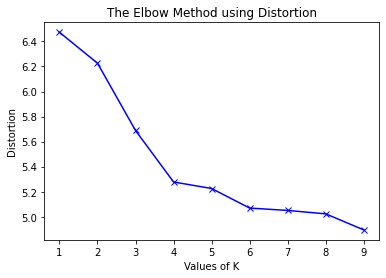

In [109]:
distortions = []
inertias = []
mapping1 = {}
mapping2 = {}

K = range(1, 10)
  
X = df_prep
for k in K:
    # Building and fitting the model
    kmeanModel = KMeans(n_clusters=k).fit(X)
    kmeanModel.fit(X)
  
    distortions.append(sum(np.min(cdist(X, kmeanModel.cluster_centers_,
                                        'euclidean'), axis=1)) / X.shape[0])
    inertias.append(kmeanModel.inertia_)
  
    mapping1[k] = sum(np.min(cdist(X, kmeanModel.cluster_centers_,
                                   'euclidean'), axis=1)) / X.shape[0]
    mapping2[k] = kmeanModel.inertia_

plt.plot(K, distortions, 'bx-')
plt.xlabel('Values of K')
plt.ylabel('Distortion')
plt.title('The Elbow Method using Distortion')
plt.show()

In [110]:
km = KMeans(n_clusters=4)
km.fit(X)
label = km.labels_
owners_safe['Cluster'] = label

In [111]:
from sklearn.decomposition import PCA
pca = PCA(2)
pca.fit(df_prep)
res = pd.DataFrame(pca.transform(df_prep))


In [112]:
pca1 = abs(pca.components_[0])
pca2 = abs(pca.components_[1])
k = 10
pca1_index = np.argpartition(pca1, len(pca1) - k)[-k:]
pca2_index = np.argpartition(pca2, len(pca2) - k)[-k:]

In [113]:
pca1_most_important = df_prep.columns[pca1_index]
pca2_most_important = df_prep.columns[pca2_index]
print("Most Important Features for X: " + str(pca1_most_important))
print("Most Important Features for Y: " + str(pca2_most_important))

Most Important Features for X: Index(['time to drop_UNI', 'days_since_last_tx', 'days_since_first_tx',
       'amount_dumped_DYDX', 'Dumped Previous Airdrop, Low Safe Activity',
       'amount_dumped_UNI', 'Low Owner Activity, Low Safe Activity',
       'Low Safe Activity, "Created Safe on Same Day', 'Cluster',
       'Short Activity Own'],
      dtype='object')
Most Important Features for Y: Index(['unique_addresses_interact', 'Dumped Two or More Airdrops',
       'Owns More Than 4 Safes', 'Multiple Wallets, Low Safe Activity',
       'days_since_first_tx', 'days_since_last_tx',
       'Low Owner Activity, Low Safe Activity',
       'Low Safe Activity, "Created Safe on Same Day', 'Cluster',
       '# of Owners for Safe Address'],
      dtype='object')


Text(0.5, 0, 'PCA Component')

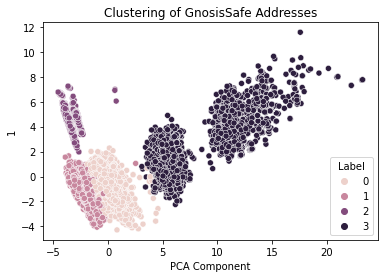

In [114]:
res['Label'] = label
plt.figure()
plt.title('Clustering of GnosisSafe Addresses')
sns.scatterplot(x =0,y =1,hue ='Label',data = res)
plt.xlabel('PCA Component')

<AxesSubplot:title={'center':'Cluster of Safe Addresses/Owner'}, xlabel='Cluster', ylabel='count'>

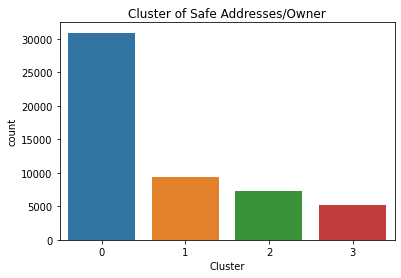

In [115]:
plt.title('Cluster of Safe Addresses/Owner')
sns.countplot(x='Cluster',data = owners_safe)

In [116]:
# from sklearn.neighbors import NearestNeighbors

# nn = NearestNeighbors(n_neighbors = 1).fit(df_prep)    
# distances, indices = nn.kneighbors(df_prep,return_distance = True)
owners_safe.to_csv('Owners Safe.csv')


In [117]:
# closest = pd.DataFrame(indices)
# owners_safe['1st Address Closest'] =  closest[0].apply(lambda x: owners_safe.loc[x,'safe_address'])

In [127]:
print('Clusters of Farmers')
print(owners_safe[owners_safe['Farm'] == 1].groupby('Cluster')['tx_hash'].count())
print('Clusters of Non Farmers')  
print(owners_safe[owners_safe['Farm'] == 0].groupby('Cluster')['tx_hash'].count())

Clusters of Farmers
Cluster
0      11
1    1354
3    1984
Name: tx_hash, dtype: int64
Clusters of Non Farmers
Cluster
0    30933
1     7963
2     7281
3     3242
Name: tx_hash, dtype: int64
